In [2]:
# Upload file

from google.colab import files
files.upload()

Saving PJME_hourly.csv to PJME_hourly.csv


{'PJME_hourly.csv': b'Datetime,PJME_MW\n2002-12-31 01:00:00,26498.0\n2002-12-31 02:00:00,25147.0\n2002-12-31 03:00:00,24574.0\n2002-12-31 04:00:00,24393.0\n2002-12-31 05:00:00,24860.0\n2002-12-31 06:00:00,26222.0\n2002-12-31 07:00:00,28702.0\n2002-12-31 08:00:00,30698.0\n2002-12-31 09:00:00,31800.0\n2002-12-31 10:00:00,32359.0\n2002-12-31 11:00:00,32371.0\n2002-12-31 12:00:00,31902.0\n2002-12-31 13:00:00,31126.0\n2002-12-31 14:00:00,30368.0\n2002-12-31 15:00:00,29564.0\n2002-12-31 16:00:00,29098.0\n2002-12-31 17:00:00,30308.0\n2002-12-31 18:00:00,34017.0\n2002-12-31 19:00:00,34195.0\n2002-12-31 20:00:00,32790.0\n2002-12-31 21:00:00,31336.0\n2002-12-31 22:00:00,29887.0\n2002-12-31 23:00:00,28483.0\n2003-01-01 00:00:00,27008.0\n2002-12-30 01:00:00,27526.0\n2002-12-30 02:00:00,26600.0\n2002-12-30 03:00:00,26241.0\n2002-12-30 04:00:00,26213.0\n2002-12-30 05:00:00,26871.0\n2002-12-30 06:00:00,28679.0\n2002-12-30 07:00:00,31509.0\n2002-12-30 08:00:00,33665.0\n2002-12-30 09:00:00,34625.0\n200

In [3]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [38]:
# Load dataset
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

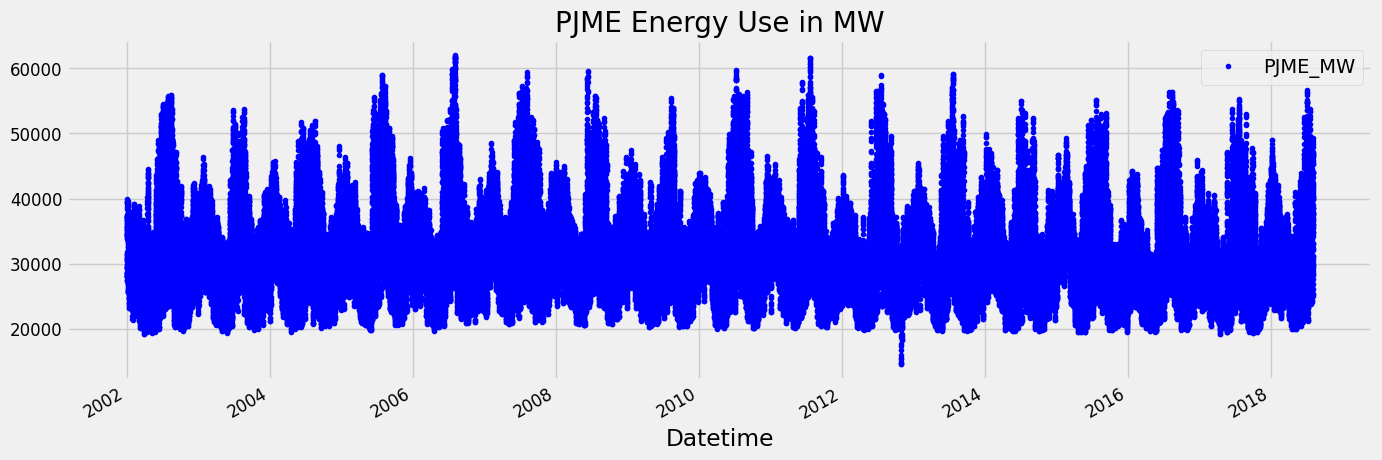

In [39]:
# Plot the data
df.plot(style='.',
        figsize=(15, 5),
        color='blue',
        title='PJME Energy Use in MW',fontsize=12
        )

plt.show()

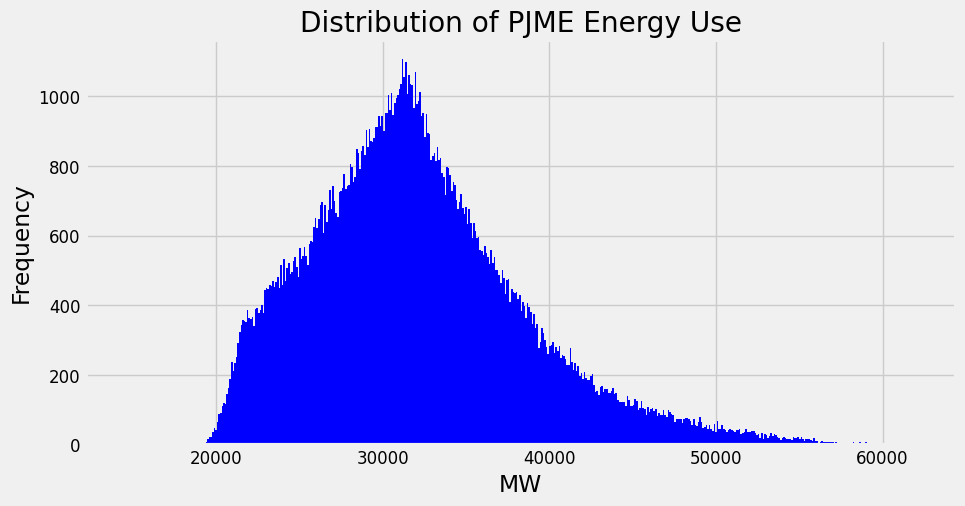

In [40]:
# Histogram
df['PJME_MW'].plot(
    kind='hist',
    bins=500,
    figsize=(10,5),
    color='blue',
    title='Distribution of PJME Energy Use',
    fontsize=12
    )
plt.xlabel('MW')
plt.ylabel('Frequency')
plt.show()

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

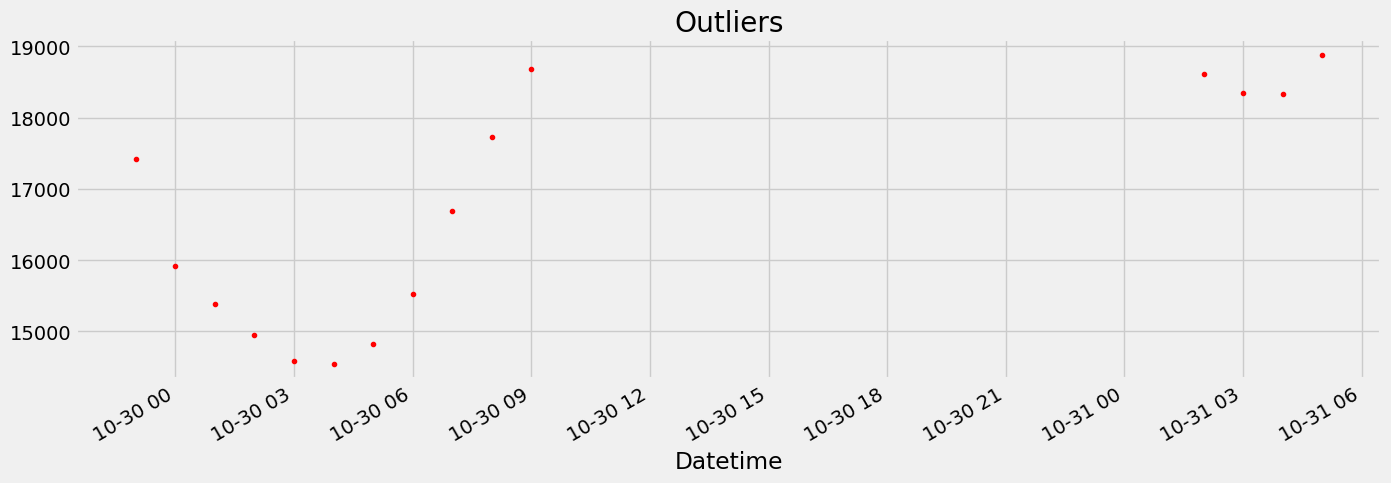

In [41]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color='red',
          title='Outliers')

In [43]:
df = df.query('PJME_MW > 19_000').copy()

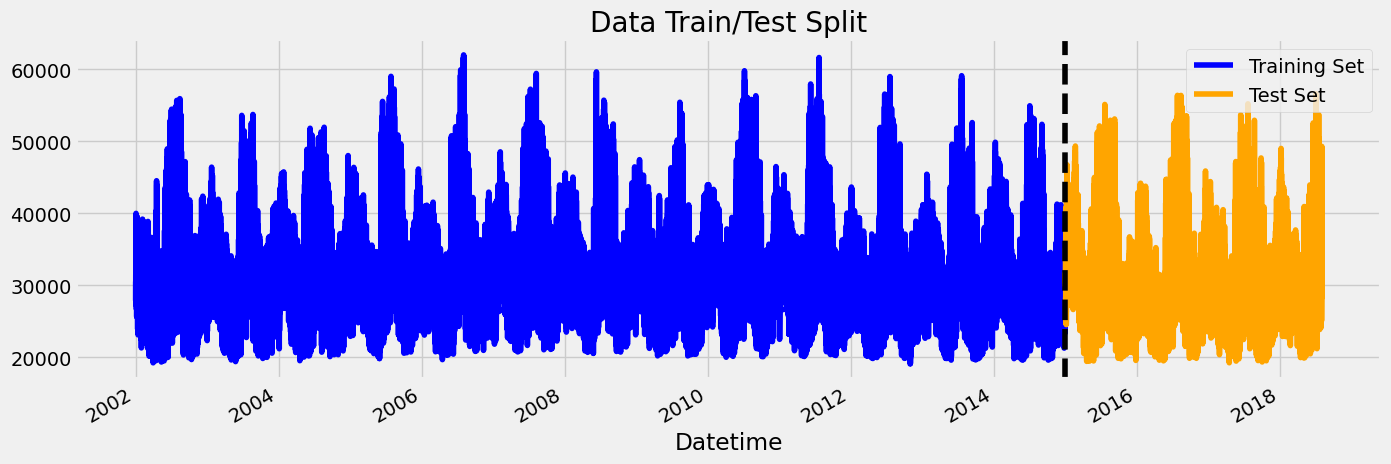

In [44]:
# Split the dataset into training and test sets based on date
train = df.loc[df.index < '01-01-2015']   # All data before 2015
test = df.loc[df.index >= '01-01-2015']   # All data from 2015 onward

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Plot training set
train.plot(
    ax=ax,
    label='Training Set',
    color='blue',
    title='Data Train/Test Split'  # Title of the plot
)

# Plot test set
test.plot(
    ax=ax,
    label='Test Set',
    color='orange'
)

# Add vertical line to indicate the split date
ax.axvline('01-01-2015', color='black', ls='--')

# Add legend with custom labels
ax.legend(['Training Set', 'Test Set'])

# Display the plot
plt.show()


In [46]:
# Create a time series split object
# n_splits=5 : number of folds
# test_size=24*365*1 : size of each test set (assuming hourly data, 1 year)
# gap=24 : gap between train and test sets (1 day)
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

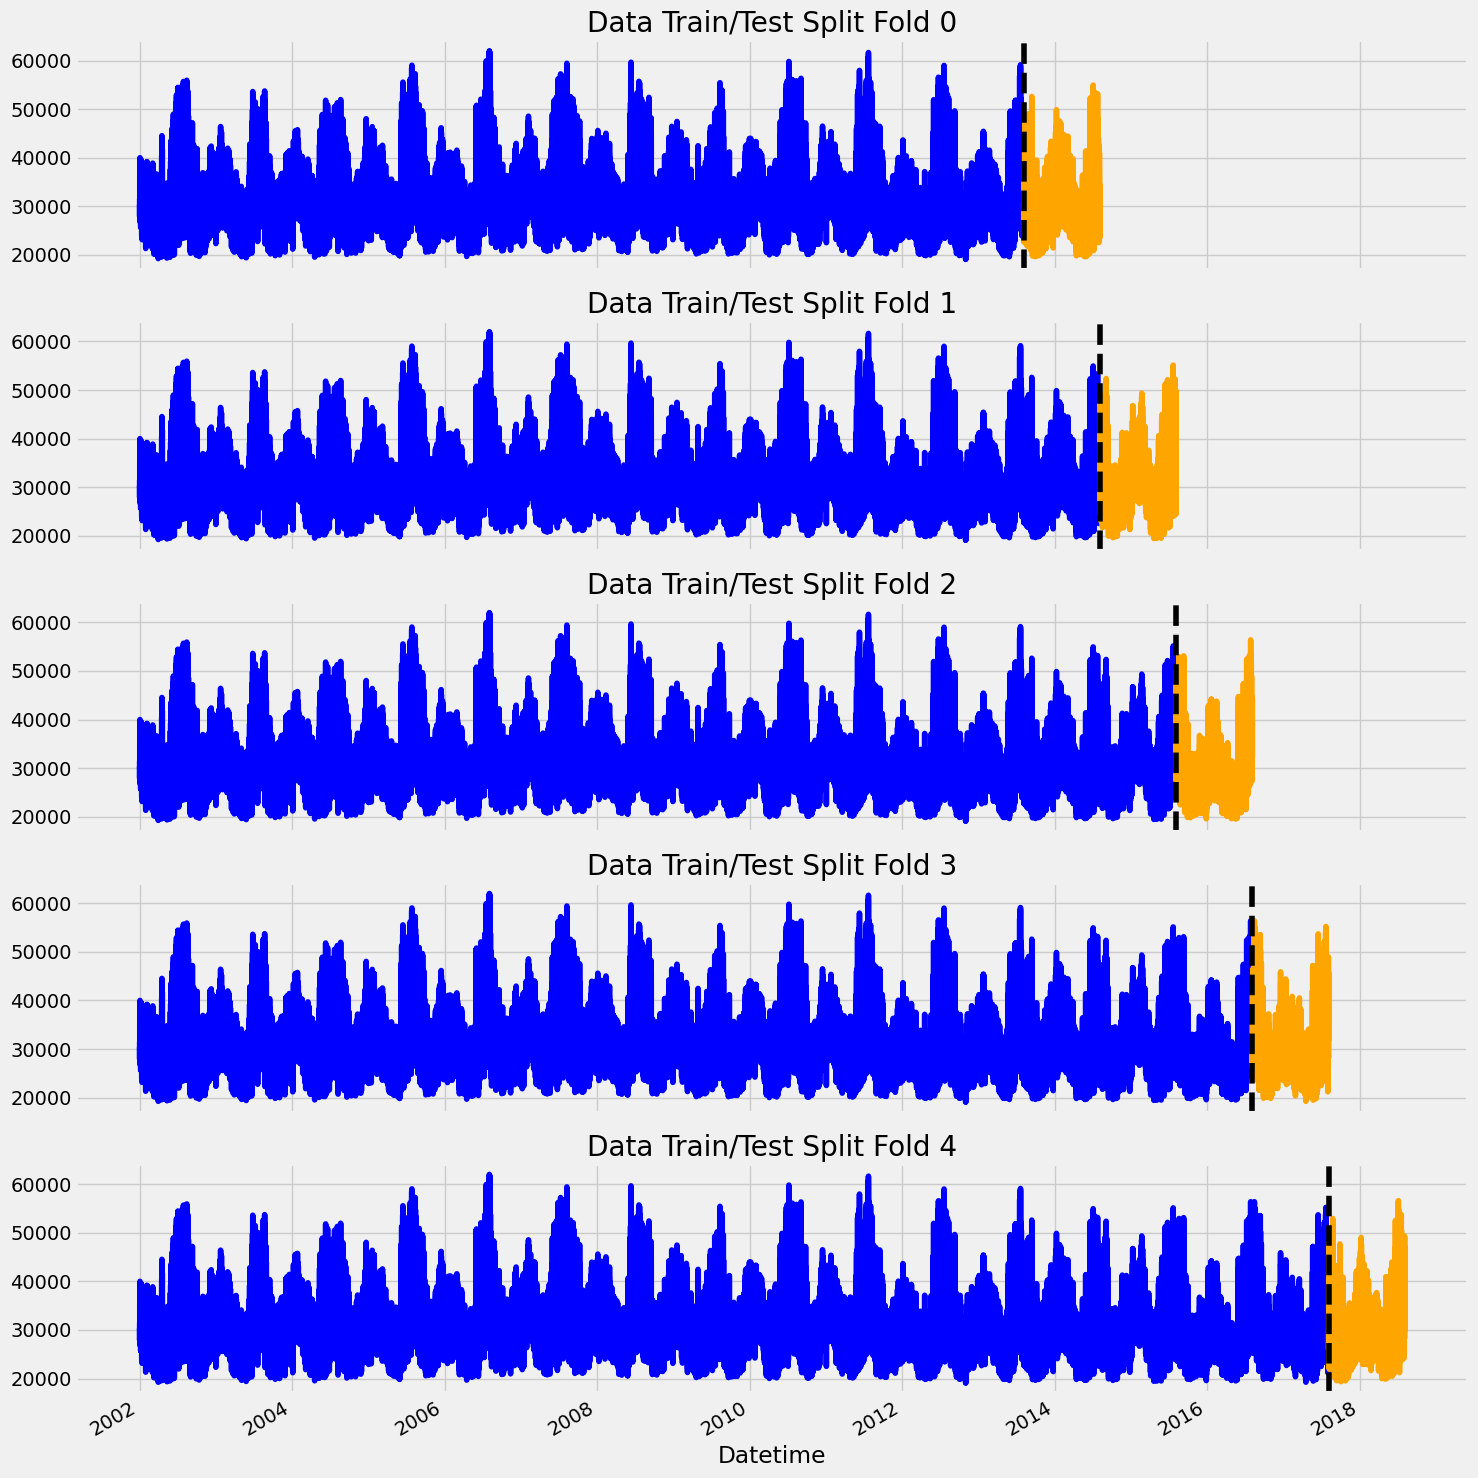

In [28]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Plot training set
    train['PJME_MW'].plot(
        ax=axs[fold],
        label='Training Set',
        color='blue',
        title=f'Data Train/Test Split Fold {fold}'
    )

    # Plot test set
    test['PJME_MW'].plot(
        ax=axs[fold],
        label='Test Set',
        color='orange'
    )

    # Add vertical line for test start
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1

plt.tight_layout()
plt.show()


In [47]:
# Create time series features based on time series index.
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [51]:
# Add lag features for the PJME_MW time series.
def add_lags(df):

    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [52]:
df = add_lags(df)

In [53]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:30:50] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:30:54] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:31:05] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:31:09] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:31:20] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[440]	validation_0-rmse:3479.88018	validation_1-rmse:4011.05271


In [54]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[np.float64(3760.8277187583353), np.float64(3420.313091887879), np.float64(3478.018038580526), np.float64(4052.5712055405547), np.float64(4001.186553933809)]


In [55]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:31:52] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [56]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [57]:
future_w_features = df_and_future.query('isFuture').copy()

In [58]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

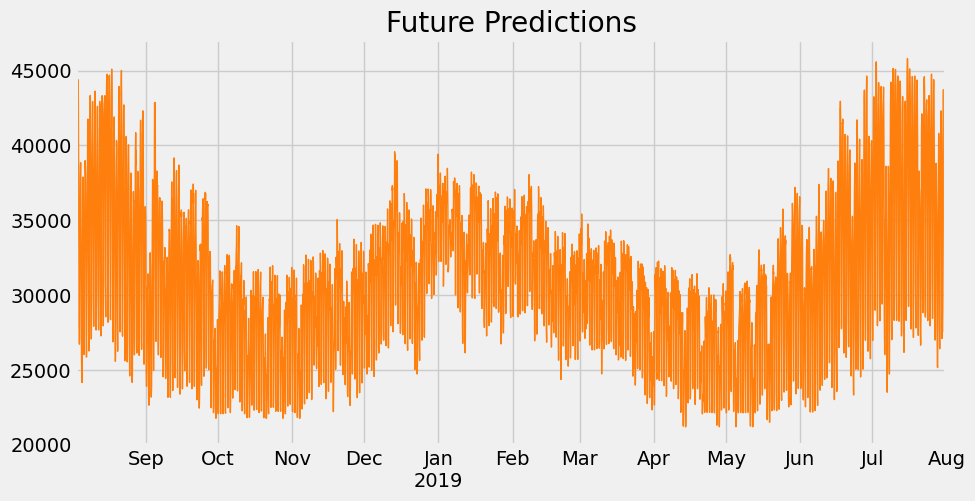

In [60]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()